<a href="https://colab.research.google.com/github/els-pnw/Feature-Engineering-Time-Series-Forecasting/blob/main/assignment1_tabularize_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [6]:
!pip install -Uq ppscore feature-engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.6/326.6 kB 2.6 MB/s eta 0:00:00


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
import pandas as pd
import numpy as np
import ppscore as pps
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from feature_engine.creation import CyclicalFeatures

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb

import matplotlib.pyplot as plt

In [80]:
# load weekly sales dataset

filename = "/content/drive/MyDrive/Colab Notebooks/\
feature-engineering-for-time-series-forecasting/\
Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales'] # rename column
df.sort_index(inplace=True, ascending=True)

# Let's extract the week number, month number, and year from the index
df['wom'] = (df.index.day -1) // 7 + 1
df['month'] = df.index.month

df['wom'] = df['wom'].astype(int)  # Convert 'week' to int

col_order = ['month', 'wom', 'sales']
df = df[col_order]

df.head()

,month,wom,sales
week,,,
2009-12-06,12,1,213000.35
2009-12-13,12,2,195810.04
2009-12-20,12,3,182396.74
2009-12-27,12,4,22007.77
2010-01-03,1,1,0.00


# Data analysis

First, explore the time series.

## Plot time series

Date range:  2009-12-06 00:00:00 2011-12-11 00:00:00

Columns:  Index(['month', 'wom', 'sales'], dtype='object')

Null values:  month    0
wom      0
sales    0
dtype: int64

Rows x Columns:  (106, 3)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2009-12-06 to 2011-12-11
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   month   106 non-null    int64  
 1   wom     106 non-null    int64  
 2   sales   106 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 3.3 KB

Data information:  None

Data types:  month      int64
wom        int64
sales    float64
dtype: object

Data description:              month         wom          sales
count  106.000000  106.000000     106.000000
mean     6.556604    2.669811  138897.618085
std      3.513458    1.270333   64441.495703
min      1.000000    1.000000       0.000000
25%      4.000000    2.000000   98287.817500
50%      7.000000    3.000000  121260.400000
75

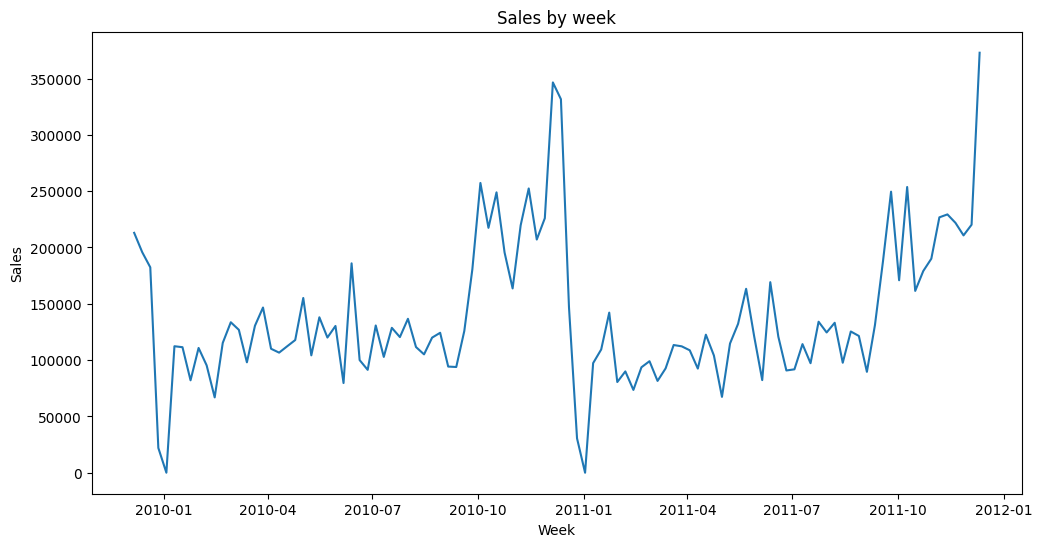

In [81]:
# What's the date range we have data for?
print("Date range: ", df.index.min(), df.index.max())

# What are our columns?
print("\nColumns: ", df.columns)

# How many nulls do we have?
print("\nNull values: ", df.isnull().sum())

# What's the shape of our dataframe?
print("\nRows x Columns: ", df.shape)

# Column info?
print("\nData information: ", df.info())

# Column dtypes?
print("\nData types: ", df.dtypes)

# Describe our data
print("\nData description: ", df.describe())

plt.figure(figsize=(12, 6))
sns.lineplot(data=df['sales'])
plt.title("Sales by week")
plt.xlabel("Week")
plt.ylabel("Sales")
plt.show()

## Missing data

Check if there are missing values in the time series.

In [82]:
print(df.isna().sum())
print(df.index.min(), df.index.max())

month    0
wom      0
sales    0
dtype: int64
2009-12-06 00:00:00 2011-12-11 00:00:00


## Missing timestamps

Check if there are missing timestamps in the index.

In [83]:
data_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='W')
missing_timestamps = data_index.difference(df.index)
print(f"Missing Timestamps: {missing_timestamps}")

Missing Timestamps: DatetimeIndex([], dtype='datetime64[ns]', freq='W-SUN')


## Seasonality

Does the time series show any obvious seasonal pattern?

<Figure size 1200x800 with 0 Axes>

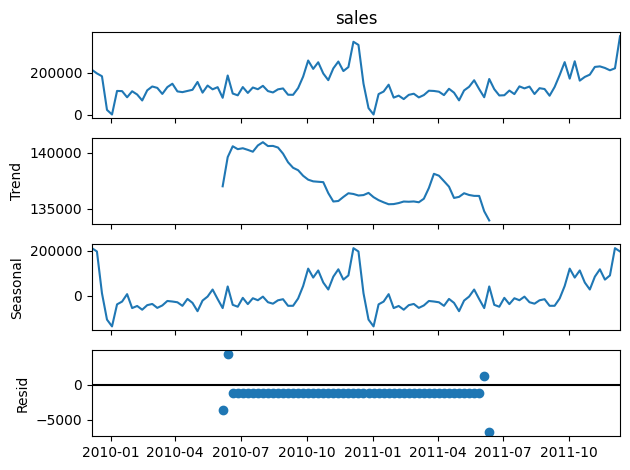

In [85]:
decomposition = seasonal_decompose(df['sales'], model='additive')

# Plot the decomposition trend, seasonal, and residuals
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

# Feature engineering

Now, let's begin to tabularize the data.

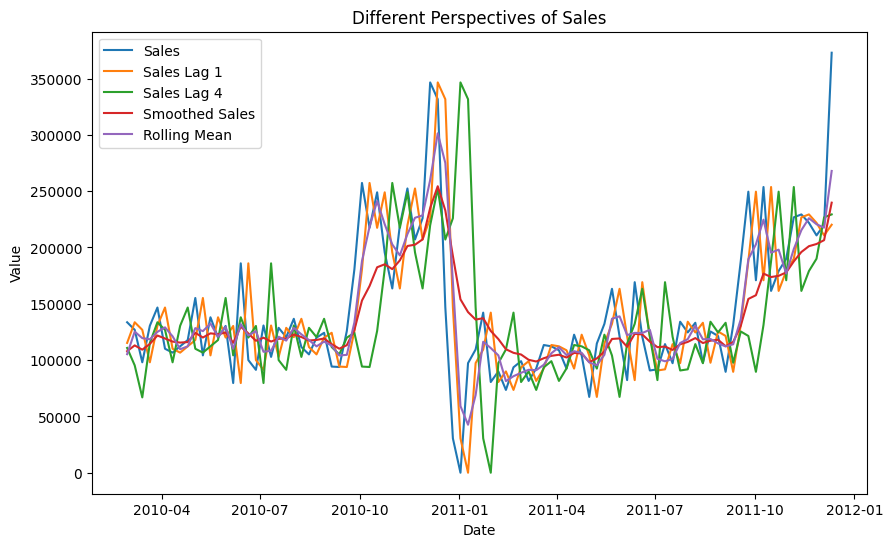

NaN values: month             0
wom               0
sales_lag_1_x     0
sales_lag_4_x     0
month_sin         0
month_cos         0
wom_sin           0
wom_cos           0
smoothed_sales    0
rolling_mean      0
sales             0
sales_lag_1_y     0
sales_lag_4_y     0
sales_lag_1       0
sales_lag_4       0
dtype: int64


,month,wom,sales_lag_1_x,sales_lag_4_x,month_sin,month_cos,wom_sin,wom_cos,smoothed_sales,rolling_mean,sales_lag_1_y,sales_lag_4_y,sales_lag_1,sales_lag_4,sales
week,,,,,,,,,,,,,,,
2010-02-28,2,4,115261.842,110790.591,0.866025,5.000000e-01,-0.951057,0.309017,107926.707014,105245.794667,115261.842,110790.591,115261.842,110790.591,133606.692
2010-03-07,3,1,133606.692,95340.552,1.000000,6.123234e-17,0.951057,0.309017,113066.380063,125252.311333,133606.692,95340.552,133606.692,95340.552,126888.400
2010-03-14,3,2,126888.400,66868.850,1.000000,6.123234e-17,0.587785,-0.809017,109263.604136,119511.697333,126888.400,66868.850,126888.400,66868.850,98040.000
2010-03-21,3,3,98040.000,115261.842,1.000000,6.123234e-17,-0.587785,-0.809017,114366.751578,118475.637000,98040.000,115261.842,98040.000,115261.842,130498.511
2010-03-28,3,4,130498.511,133606.692,1.000000,6.123234e-17,-0.951057,0.309017,121833.861836,125076.573667,130498.511,133606.692,130498.511,133606.692,146691.210


In [77]:
VARS = ['sales']

tmp = df[VARS].shift(freq='1W')

tmp.columns = [v + "_lag_1" for v in VARS]
df = df.merge(tmp, how='left', left_index=True, right_index=True)

tmp = df[VARS].shift(freq='4W')

tmp.columns = [v + "_lag_4" for v in VARS]
df = df.merge(tmp, how='left', left_index=True, right_index=True)

cyclical = CyclicalFeatures(
        variables=["month", "wom"],  # The features we want to transform.
        drop_original=False,  # Whether to drop the original features.
    )

df = cyclical.fit_transform(df)

alpha = 0.2
smoothed_data = df['sales'].ewm(alpha=alpha).mean()
df['smoothed_sales'] = smoothed_data

window_size = 3
rolling_mean = df['sales'].rolling(window=window_size).mean()
df['rolling_mean'] = rolling_mean

df.dropna(inplace=True)

plt.figure(figsize=(10, 6))

# Plot each column using Seaborn's lineplot
sns.lineplot(x=df.index, y=df['sales'], label='Sales')
sns.lineplot(x=df.index, y=df['sales_lag_1'], label='Sales Lag 1')
sns.lineplot(x=df.index, y=df['sales_lag_4'], label='Sales Lag 4')
sns.lineplot(x=df.index, y=df['smoothed_sales'], label='Smoothed Sales')
sns.lineplot(x=df.index, y=df['rolling_mean'], label='Rolling Mean')

# Set the title
plt.title('Different Perspectives of Sales')

# Set the x-axis label
plt.xlabel('Date')

# Set the y-axis label
plt.ylabel('Value')

# Show the legend
plt.legend()

# Show the plot
plt.show()
print(f"NaN values: {df.isna().sum()}")

columns = [c for c in df.columns if c != 'sales']
col_order = columns + ['sales']

df = df[col_order]
df.head()

## Predictive Power Score
Let's see if we can assess the predicitve power of our data features.

[About ppscore](https://github.com/8080labs/ppscore)

<Axes: xlabel='x', ylabel='y'>

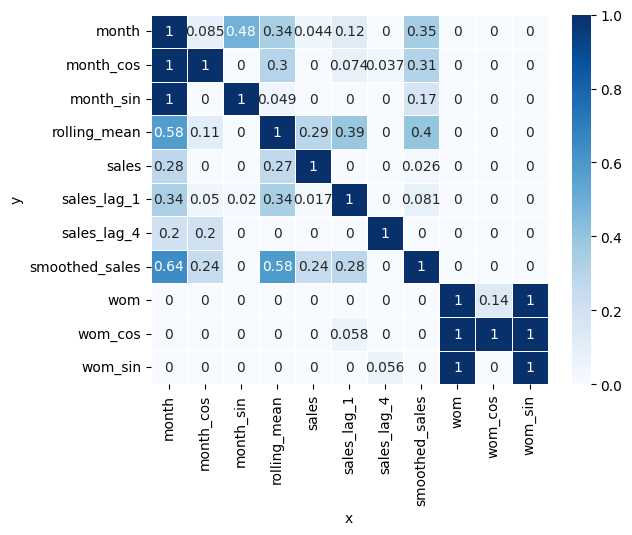

In [71]:
matrix_df = pps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [27]:
split_date = '2011-07-24'

X_train = df[df.index <= split_date]
X_test = df[df.index > split_date]

y_train = X_train['sales'].copy()
y_test = X_test['sales'].copy()

X_train = X_train.drop(['sales'], axis=1)
X_test = X_test.drop(['sales'], axis=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train.head())


(82, 10) (20, 10) (82,) (20,)
            month  wom  sales_lag_1  sales_lag_4  month_sin  month_cos  \
week                                                                     
2010-01-03      1    1    22007.770    213000.35        0.5   0.866025   
2010-01-10      1    2        0.000    195810.04        0.5   0.866025   
2010-01-17      1    3   112318.850    182396.74        0.5   0.866025   
2010-01-24      1    4   111460.470     22007.77        0.5   0.866025   
2010-01-31      1    5    82065.331         0.00        0.5   0.866025   

                 wom_sin   wom_cos  smoothed_sales   rolling_mean  
week                                                               
2010-01-03  9.510565e-01  0.309017    95740.068253   68134.836667  
2010-01-10  5.877853e-01 -0.809017   100233.839869   44775.540000  
2010-01-17 -5.877853e-01 -0.809017   103075.000456   74593.106667  
2010-01-24 -9.510565e-01  0.309017    98025.981799  101948.217000  
2010-01-31 -2.449294e-16  1.000000   100974

## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

In [28]:
print("Naive model rmse: ", mean_squared_error(
    y_train, X_train['sales_lag_1'], squared=False))

print("Naive model rmse: ", mean_squared_error(
    y_test, X_test['sales_lag_1'], squared=False))

Naive model rmse:  46757.84146986234
Naive model rmse:  54278.345685340195


In [29]:
print("Naive model rmse: ", mean_squared_error(
    y_train, X_train['smoothed_sales'], squared=False))

print("Naive model rmse: ", mean_squared_error(
    y_test, X_test['smoothed_sales'], squared=False))

Naive model rmse:  41237.36423691937
Naive model rmse:  45393.213336503366


## Machine Learning

### Lasso

In [30]:
linear_model = Lasso()
linear_model.fit(X_train, y_train)

print("Lasso train rmse: ",
    mean_squared_error(y_train, linear_model.predict(X_train), squared=False))

print("Lasso test rmse: ",
    mean_squared_error(y_test, linear_model.predict(X_test), squared=False))

Lasso train rmse:  31543.829306909203
Lasso test rmse:  30744.461333458028


### LinearRegression

In [31]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print("Linear Regression train rmse: ",
    mean_squared_error(y_train, lr_model.predict(X_train), squared=False))
print("Linear Regression test rmse: ",
    mean_squared_error(y_test, lr_model.predict(X_test), squared=False))

Linear Regression train rmse:  31543.82855553211
Linear Regression test rmse:  30747.531489270023


### XGBoostRessor

In [32]:
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=20000,
    learning_rate=0.0005,
    eval_metric="rmse",
    early_stopping_rounds=10,
)

xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

print("XGBoost train rmse: ",
    mean_squared_error(y_train, xgb_model.predict(X_train), squared=False))
print("XGBoost test rmse: ",
    mean_squared_error(y_test, xgb_model.predict(X_test), squared=False))


XGBoost train rmse:  1226.9424749210334
XGBoost test rmse:  28853.74679267971
